# Factor Analysis (Dimensionality Reduction)

In [4]:
# Import some helper functions (please ignore this!)
from utils import *
from cs349 import *

**Context:** As we found in the chapter on Gaussian Mixture Models (GMMs), our data might contain latent structure. In the IHH context, for example, each patient can be described by some underlying condition that explains their data, where there's a fixed number of possible conditions. However, what happens if the hidden structure is not discrete, but is continuous. By this, we mean that, instead of supposing there exists a discrete number of latent underlying patient conditions, there may be a *spectrum* of underlying conditions. Every patient lies somewhere on this spectrum, and our goal uncover it. 


**Challenge:** In order to place patients on this "spectrum," we'll have to use a continuous latent variable. We will introduce a new model, called Factor Analysis, which does exactly this. However, when using a continuous latent variable, we'll run into some challenges. First, we'll notice that we need a continuous version of the law of total probability. Second, we'll need some efficient computational scheme to apply the law of total probability in practice.

**Outline:** 
* Introduce the Factor Analysis model
* Introduce the continuous version of the law of total probability
* Implement Factor Analysis in `NumPyro`

**Data:** In the past week, the IHH has been hit hard by some unknown disease, spreading through the in-patient population. The IHH's Center for Epidemiology has recently been tasked with understanding the disease and stopping its spread. They have been working hard around the clock, taking patient saliva samples and screening it under a microscope to understand what's going on. They sent you a data set consisting of microscope images---each $24 \times 24$ in size (576 pixels in total)---in which each pixel takes on values from $0.0$ to $1.0$ (black to white). To summarize, each observation, $x_n$ is a 576-long array of values between $[0, 1]$: $x_n \in [0, 1]^{567}$.

You opened one of the microscope images and here's what you found:

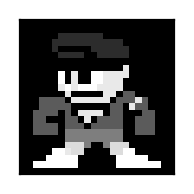

In [11]:
import jax.numpy as jnp

# Load the data
data = jnp.load('data/microscope.npy')

# Visualize one of the microscope images
visualize_microscope_samples(data[:1])

The microscope image actually shows an intergalactic virus! And this specific intergalactic virus seems to be wearing a hat! If it weren't for the epidemic at the IHH, this would have been super cute. Let's have a look at a bunch more of these. 

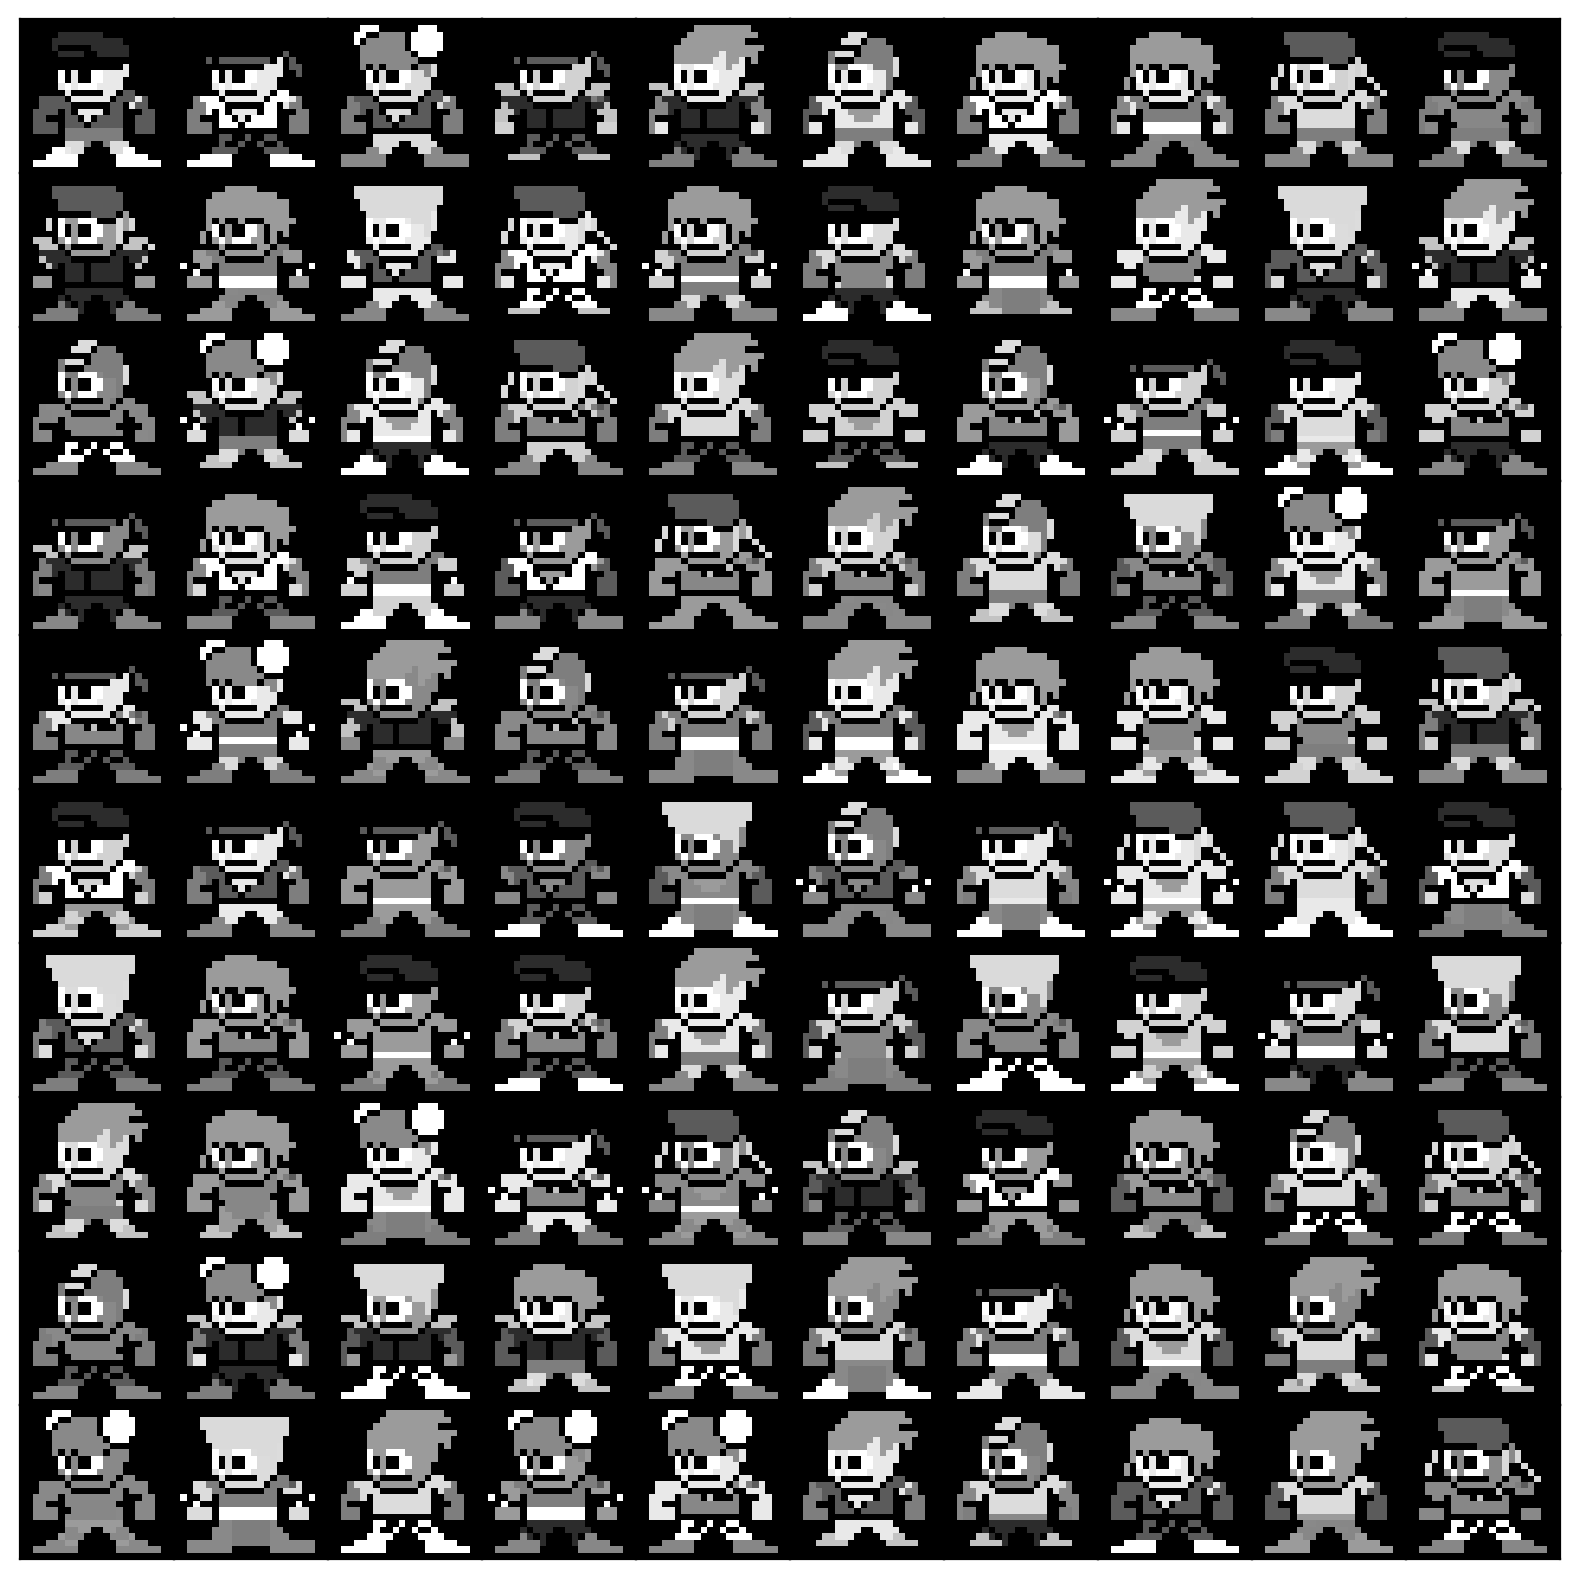

In [12]:
visualize_microscope_samples(data[:100])

It seems like we have a whole collection of viruses here, each different, and wreaking havoc in a different way. Your colleagues at the Center for Epidemiology have limited bandwidth. They can't possibly look at every virus sample collected from every patient to understand the various mechanisms that cause the disease. As such, they've enlisted you to help them out. They hypothesize that although these viruses look different, most aren't important for the presentation of the disease. As such, they would like you to learn a low-dimensional representation so that they can better explore these viruses.

## Factor Analysis Model

**Data Generating Process.** So how can we help our IHH colleagues? Let's think about their hypothesis. They said they believe there the data can actually be represented by a small number of dimensions. Using this idea, let's assume our data *was actually* generated by a distribution on a low dimensional space. For simplicity, let's go with a 2-dimensional Gaussian with unit variance:
\begin{align}
z_n &\sim p_Z(\cdot) = \mathcal{N}\left( 
\begin{bmatrix} 0.0 \\ 0.0 \end{bmatrix},
\begin{bmatrix} 1.0 & 0.0 \\ 0.0 & 1.0 \end{bmatrix}
\right).
\end{align}
$Z$ represents our *latent* variable, since we never actually observed it---we only observed the high-dimensional microscope images. To make notation easier, we will denote square matrices with 1s along the diagonal and 0s everywhere else with $I_d$ (this is called the [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix)). We will use the subscript-$d$ to denote the size of the matrix. Using this notation, we have:
\begin{align}
z_n &\sim p_Z(\cdot) = \mathcal{N}(0, I_2)
\end{align}

Next, we need some way of translating the latent variable into our observed variable. That is, we need to specify the distribution of the observed data given the latent variable:
\begin{align}
x_n | z_n &\sim p_{X | Z}(\cdot | z_n; \theta),
\end{align}
where $\theta$ are the parameters of the distribution. We can do this by assuming there exists some function $f(\cdot; W)$, with parameters $W$, that maps the low-dimensional latent space to the high-dimensional observation space. In our case, $f(\cdot; W)$ will map a 2-dimensional space to a 576-dimensional space: $f: \mathbb{R}^2 \rightarrow [0, 1]^{576}$. This function can be anything we'd like it to be. In many applications of factor analysis (e.g. in psychology), it's common to use a linear function; however, for image data, like in our case, it's better to use a non-linear function. We will use a neural network. 

We can then assume that there's some "observation error" (e.g. microscope inaccuracies) that corrupt the translation from the low-dimensional space to the observed space. As is common in factor analysis, we'll go with a multivariate Gaussian for now:
\begin{align}
x_n | z_n &\sim p_{X | Z}(\cdot | z_n; \theta) = \mathcal{N}(f(z_n;  W), \sigma^2 \cdot I_{576}),
\end{align}
where $\theta = \{W, \sigma \}$ are our model parameters, and $\sigma^2 \cdot I_{576}$ is a matrix of $\sigma^2$ along the diagonal and 0s everywhere else. This covariance matrix indicates that the observation errors for each pixel are uncorrelated. 

Putting this all together, we have the following generative process:
\begin{align}
z_n &\sim p_Z(\cdot) = \mathcal{N}(0, I_2) \\
x_n | z_n &\sim p_{X | Z}(\cdot | z_n; \theta) = \mathcal{N}(f(z_n;  W), \sigma^2 \cdot I_{576})
\end{align}

**Directed Graphical Model.** Depicting this generative process as a DGM, we have:

<div class="canva-centered-embedding">
  <div class="canva-iframe-container">
    <iframe loading="lazy" class="canva-iframe"
      src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGMi4QzMVk&#x2F;H47_jnFt704nduRNv9JhRw&#x2F;view?embed">
    </iframe>
  </div>
</div>

Apart from the parameters, you can see that this model is identical to that of a GMM. The only differences are that:
1. The latent variable is continuous in the factor analysis model, while its discrete in a GMM.
2. A factor analysis model uses a fancy function $f(\cdot; W)$ to map samples from the latent space to the observed space. In contrast, in a GMM, samples from the latent space are discrete---they are used to choose which "cluster" to use to sample the observed data. 

## Fitting Factor Analysis Models to Data

**Challenges Deriving the MLE.** Now that we've specified our model, we're ready to derive its MLE objective. As we've seen with the GMM, we'll run into challenges; our generative process specifies a *joint* distribution over random variables $X$ and $Z$---but we just want to find the parameters $\theta$ that maximize what we observed, $X$. 

\begin{align}
p(\mathcal{D}; \theta) &= \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \\
&= \prod\limits_{n=1}^N p_X(x_n; \theta)
\end{align}
Looking at the above, what is $p_X(x_n; \theta)$? Our data-generating process gives us the following joint distribution:
\begin{align}
p_{X | Z}(x_n, z_n; \theta) &= p_{X | Z}(x_n | z_n; \theta) \cdot p_Z(z_n; \theta)
\end{align}
Somehow, we need to compute $p_X(x_n; \theta)$ from $p_{X | Z}(x_n, z_n; \theta)$. 

As before, we'll use the law of total probability to marginalize out $Z$ and compute $p_X(x_n; \theta)$. Since $Z$ is a continuous random variable, we need a continuous version of the law of total probability.

**Law of Total Probability (Continuous).** Recall that the law of total probability tells us how to compute a marginal distribution from a joint distribution. Suppose you have two random variables, $A$ and $B$, and suppose that $A$ is continuous with support $S$. Then the law of total probability says we can compute the marginal $p_B(b)$ from the joint $p_{A, B}(a, b)$ as follows:
\begin{align}
p_B(b) &= \int\limits_{a \in S} p_{A, B}(a, b) \cdot da
\end{align}
The only difference between the discrete and continuous versions of this law is that in the continuous case we have an *integral* instead of a *sum*. 

As in the discrete case, we can also write it using expectations by factorizing the joint distribution:
\begin{align}
p_B(b) &= \int\limits_{a \in S} p_{A, B}(a, b) \cdot da \\
&= \int\limits_{a \in S} p_{B | A}(b | a) \cdot p_A(a) \cdot da \\
&= \mathbb{E}_{a \sim p_A(\cdot)} \left[ p_{B | A}(b | a) \right] \\
\end{align}
The law of total probability therefore says that the probability of $B$ is that of $B$ given $A = a$, averaged over all values of $a$. 

**The MLE Objective.** Using the law of total probaility, we can finish our derivation of the MLE objective:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_\theta \log p(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_\theta \log \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log p(\mathcal{D}_n; \theta) \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log p_X(x_n; \theta) \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log \int\limits_{-\infty}^\infty p_{X, Z}(x_n, z_n; \theta) \cdot dz_n \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log \int\limits_{-\infty}^\infty p_{X | Z}(x_n | z_n; \theta) \cdot p_Z(z_n) \cdot dz_n \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log \mathbb{E}_{z_n \sim p_Z(\cdot)} \left[ p_{X | Z}(x_n | z_n; \theta) \right] \\
\end{align}

**Computational Challenges.**

## Factor Analysis in `NumPyro`

* Ask to generate samples
* Ask to decode along a latent path

**Acknowledgements.** Data adapted from [this repository](https://huggingface.co/datasets/calcuis/pixel-character). 